In [11]:
# A sandbox for testing a script which collects statistics on which antennas are SARFI (Single Antenna RFI)

In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Import regular packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import pickle
import itertools
from datetime import datetime
from astropy.time import Time
import os

In [14]:
# Next we'll import the seticore viewer package: 
# Unfortunately, it can be a little fiddley
# I'm using the Python 3.7 (base) conda environment on blpc1 
# I was having issues with the Python 3.9 seticore_viewer conda environment I created on blpc1
# The standard maintained branch is https://github.com/MydonSolutions/seticore
# although I added some additional functionality on my own fork at https://github.com/NMStiegler/seticore
# so if my plots look different that's why
# These packages may need to be pip installed if they're not already
try:
    from seticore import viewer
except:
    # # May need to install pycapnp
    # try:
    #     %pip install pycapnp
    # except:
    #     %conda install pycapnp
    # # %pip install "git+https://github.com/NMStiegler/seticore#egg=seticore&subdirectory=python"
    # %pip install pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
    # from seticore import viewer
    print('error')

In [15]:
# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()
assert(hostname == "cosmic-gpu-1")

In [16]:
# Loading in files from a file
file_info = pd.read_csv("/home/nstiegle/BL-COSMIC-2024-proj/stamps/file_info.csv")
print(file_info.shape)
file_info.head()

(100, 11)


,id,file_uri,file_local_enumeration,tuning,tstart,signal_frequency,signal_drift_rate,signal_snr,start_channel,signal_power,signal_incoherent_power
0,900274777,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,76,BD,60212.560625,42889.438718,0.000000,17.512360,59221,8.297027e+11,8.297027e+11
1,900274491,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,16,AC,60212.560625,43192.078426,0.000000,9.672808,373071,5.938950e+11,5.487897e+11
2,900273779,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,52,BD,60212.560625,42811.550000,0.000000,13.936493,117565,7.266612e+11,6.518559e+11
3,900276108,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,168,AC,60212.560625,43158.487883,0.000000,17.988485,63456,7.799876e+11,7.799876e+11
4,900275004,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,44,AC,60212.560625,43159.659614,-0.242532,192.167343,153492,6.667380e+12,6.667380e+12


In [17]:
# Convert a filepath from pointing to a .hits
# to a .stamps file for the same uri
# If given a .stamps ending, doesn't change it
def stamp_filepath_of(hits_filepath):
    return hits_filepath.replace('.hits', '.0000.stamps')

# Print the useful part of the file path
def print_path_end(file_uri):
    return ".".join(file_uri.split("/")[-1].split(".")[-6:-4])

In [18]:
# Get the power and snr of the signal in each antenna of a stamp file
# Parameter:
# - stamp (the stamp in the stamp file)
# Returns:
# - (list of antenna snrs, list of signals signals)
def antenna_signal_snr_power(stamp):
    # Get the powers in the frequency bins of each antenna by summing 
    # over polarization and complex magnitude
    # Also rearrange so indices are (antenna, time bin, frequency bin)
    antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4)).transpose(2, 0, 1)
    snr_and_signals = np.array([stamp.snr_and_signal(antenna_power) for antenna_power in antenna_powers])
    return (snr_and_signals[:, 0], snr_and_signals[:, 1])

In [19]:
# Given a URI and hit frequency finds the corresponding stamp file
# Parameter:
# - hit_uri - The uri from the hit (ending in .hits or .stamps)
# - frequency - The frequency from the hit (in MHz)
# - threshold - How close in frequency in hz the hit_frequency and the frequency of the stamp have
#               to be to say the hit is in the stamp file. Most stamp files are 1000Hz wide so
#               +/-500Hz from the center signal is the default
# Returns:
# - The stamp object corresponding to that hit in that stamp file (if it exists) otherwise None
def find_stamp_of_hit(hit_uri, hit_frequency, threshold=500):
    stamp_uri = stamp_filepath_of(hit_uri)
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for stamp in stamps_gen:
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None

In [20]:
df = file_info.copy()

In [21]:
# Calculate the antenna snrs and signals for each hit
all_snrs = []
all_signals = []
for i in range(len(file_info)):
    row = file_info.iloc[i]
    stamp = find_stamp_of_hit(row.file_uri, row.signal_frequency)
    if stamp != None:
        snrs, signals = antenna_signal_snr_power(stamp)
    else:
        print(f"Row {i} couldn't find a stamp file :/")
        snrs = []
        signals = []

    all_snrs.append(snrs)
    all_signals.append(signals)

# Make new columns in the df for the antenna snrs and signals on each hit
file_info["antenna_snrs"] = all_snrs
file_info["antenna_signals"] = all_signals

/home/nstiegle/miniforge3/envs/stamp_viewer/lib/python3.7/site-packages/seticore/viewer.py:125: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(filepath)


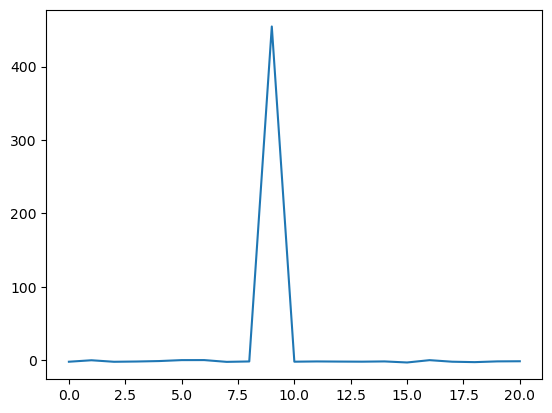

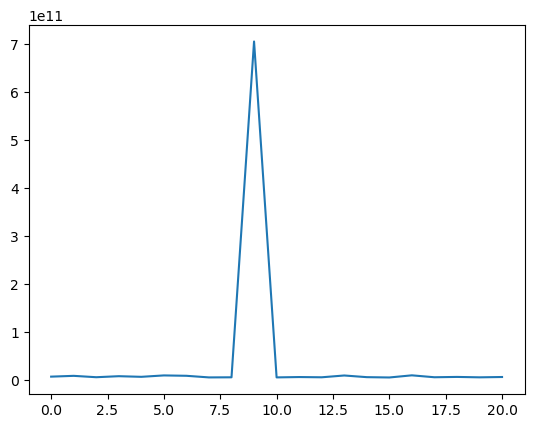

In [22]:
to_check = 0
plt.plot(file_info.antenna_snrs[to_check])
plt.show()
plt.plot(file_info.antenna_signals[to_check])
plt.show()

In [23]:
# It does take a while - can I benchmark it?

In [24]:
%%timeit
# Calculate the antenna snrs and signals for each hit
all_snrs = []
all_signals = []
for i in range(len(file_info)):
    row = file_info.iloc[i]
    stamp = find_stamp_of_hit(row.file_uri, row.signal_frequency)
#     if stamp != None:
#         snrs, signals = antenna_signal_snr_power(stamp)
#     else:
#         print(f"Row {i} couldn't find a stamp file :/")
#         snrs = []
#         signals = []

#     all_snrs.append(snrs)
#     all_signals.append(signals)

# # Make new columns in the df for the antenna snrs and signals on each hit
# file_info["antenna_snrs"] = all_snrs
# file_info["antenna_signals"] = all_signals

/home/nstiegle/miniforge3/envs/stamp_viewer/lib/python3.7/site-packages/seticore/viewer.py:125: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(filepath)


KeyboardInterrupt: 

In [ ]:
%%timeit
# Calculate the antenna snrs and signals for each hit
all_snrs = []
all_signals = []
for i in range(len(file_info)):
    row = file_info.iloc[i]
    stamp = find_stamp_of_hit(row.file_uri, row.signal_frequency)
    if stamp != None:
        snrs, signals = antenna_signal_snr_power(stamp)
    else:
        print(f"Row {i} couldn't find a stamp file :/")
        snrs = []
        signals = []

#     all_snrs.append(snrs)
#     all_signals.append(signals)

# # Make new columns in the df for the antenna snrs and signals on each hit
# file_info["antenna_snrs"] = all_snrs
# file_info["antenna_signals"] = all_signals

12.9 s ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
# Calculate the antenna snrs and signals for each hit
all_snrs = []
all_signals = []
for i in range(len(file_info)):
    row = file_info.iloc[i]
    stamp = find_stamp_of_hit(row.file_uri, row.signal_frequency)
    if stamp != None:
        snrs, signals = antenna_signal_snr_power(stamp)
    else:
        print(f"Row {i} couldn't find a stamp file :/")
        snrs = []
        signals = []

    all_snrs.append(snrs)
    all_signals.append(signals)

# # Make new columns in the df for the antenna snrs and signals on each hit
# file_info["antenna_snrs"] = all_snrs
# file_info["antenna_signals"] = all_signals

12.9 s ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
# Calculate the antenna snrs and signals for each hit
all_snrs = []
all_signals = []
for i in range(len(file_info)):
    row = file_info.iloc[i]
    stamp = find_stamp_of_hit(row.file_uri, row.signal_frequency)
    if stamp != None:
        snrs, signals = antenna_signal_snr_power(stamp)
    else:
        print(f"Row {i} couldn't find a stamp file :/")
        snrs = []
        signals = []

    all_snrs.append(snrs)
    all_signals.append(signals)

# Make new columns in the df for the antenna snrs and signals on each hit
file_info["antenna_snrs"] = all_snrs
file_info["antenna_signals"] = all_signals

12.9 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
